# **PIPELINE DE DADOS DO BIGQUERY - Ultima atualização: 2025/02/23**
### Inicialiada dia 2025/02/15
----------------------------------------------------------- 

## **INSTALANDO DEPENDENCIAS 🏗️**

In [1]:
!pip install -r requirements.txt

## **IMPORTANDO LIBS 📚**

In [2]:
# Imports necessarios
import matplotlib.pyplot as plt
from google.oauth2 import service_account #Conexão com Google Cloud
from datetime import datetime, timedelta
from google.cloud import bigquery
import pandas_gbq as pg #Conexão com BigQuery pelo Pandas
import pandas as pd
import os

from addons.Config.Engine import *

## **PATHS 🚶**

In [3]:
# Assim pode rodar em Linux e no Windows sem BO de path.
path_credentials    = os.path.join("addons",       "Credentials",  ACESS_BIGQUERY["CREDENTIALS_NAME"])
path_sql            = os.path.join("queries",       "Viagens",      "Planejada_U_Realizada", "Merge.sql")
path_csv_cache      = os.path.join("addons",       "TEMP",         "CacheMerge.csv")

## **AUTENTICANDO NO BIGQUERY 🚪**

In [4]:
#Lendo a chave de acesso da conta do serviço
credentials         = service_account.Credentials.from_service_account_file(path_credentials)

## **LENDO OS DADOS 📖**

In [5]:
######################################################
## 1° Execution Time 42.2s                          ##
## 2° Execution Time 23.5s                          ##
## 3° Execution Time 21.9s                          ##
## 4° Execution Time 23.0s                          ##
## NA SEGUNDA EXECUÇÃO ESTABILIZA, EXISTE CACHE     ## 
## NO BIGQUERY!                                     ##
## ------------------------------------------------ ##
##   AFERIR FIGURA 1 NA PASTA 'Provas' EM MODULES   ##
##   PARA OP /addons/TEMPO CORRIDO E FIGURA 2       ##
##   PARA A VELOCIDADE DE INTERNET                  ##
######################################################

# ABRINDO ARQUIVO DE SQL PARA CONSULTAR NO BANCO
with open(path_sql, 'r') as file:
    query = file.read()

# CRIA A PASTA ATÉ O FILE DESEJADO CASO NÃO EXISTA
os.makedirs(path_csv_cache.replace(os.path.basename(path_csv_cache),""), exist_ok=True)

# SO IRÁ LER NO BANCO UMA VEZ, RESTANTE PEGA NO CACHE
if os.path.exists(path_csv_cache) is False:
    # BUSCANDO DADOS NO BIGQUERY JÁ COM AS VIAGENS REALIZADAS COM MERGE NA VIAGENS PLANEJADAS
    df              = pg.read_gbq(query,project_id=ACESS_BIGQUERY["PROJECT_NAME"], credentials=credentials)
    # SALVANDO O ARQUIVO EM CSV PARA não CONSULTAR NO BANCO NOVAMENTE
    df.to_csv(path_csv_cache, encoding='utf-8', index=False, sep=';')
else:
    # LENDO DO CACHE, CASO RODE PELA SEGUNDA VEZ
    df              = pd.read_csv(path_csv_cache, sep=';')

## **TYPAGEM DE DADOS 🎲🔨**

In [6]:
# analisando tipagem dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33451 entries, 0 to 33450
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   servico_VP           33451 non-null  object
 1   service_VR           33451 non-null  object
 2   datetime_partida_VP  33451 non-null  object
 3   datetime_partida_VR  33451 non-null  object
 4   datetime_chegada_VP  33451 non-null  object
 5   datetime_chegada_VR  33451 non-null  object
 6   tempo_viagem_VP      33451 non-null  int64 
 7   tempo_viagem_VR      33451 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


In [7]:
df['servico_VP']                = df['servico_VP'].astype("string")
df['service_VR']                = df['service_VR'].astype("string")
df['datetime_partida_VP']       = pd.to_datetime(df['datetime_partida_VP'], format='%Y-%m-%d %H:%M:%S')
df['datetime_partida_VR']       = pd.to_datetime(df['datetime_partida_VR'], format='%Y-%m-%d %H:%M:%S')
df['datetime_chegada_VP']       = pd.to_datetime(df['datetime_chegada_VP'], format='%Y-%m-%d %H:%M:%S')
df['datetime_chegada_VR']       = pd.to_datetime(df['datetime_chegada_VR'], format='%Y-%m-%d %H:%M:%S')
df['tempo_viagem_VP']           = df['tempo_viagem_VP'].convert_dtypes(int)
df['tempo_viagem_VR']           = df['tempo_viagem_VR'].convert_dtypes(int)

In [8]:
print(df.dtypes)

servico_VP             string[python]
service_VR             string[python]
datetime_partida_VP    datetime64[ns]
datetime_partida_VR    datetime64[ns]
datetime_chegada_VP    datetime64[ns]
datetime_chegada_VR    datetime64[ns]
tempo_viagem_VP                 Int64
tempo_viagem_VR                 Int64
dtype: object


## **ESCOLHENDO COLUNAS PARA A ANÁLISE 🎯**

In [9]:
cols_choice = [
    "servico_VP",
    "datetime_partida_VP",
    "datetime_partida_VR",
    "datetime_chegada_VP",
    "datetime_chegada_VR",
    "tempo_viagem_VP",
    "tempo_viagem_VR"
]

rename_cols = {
    "servico_VP":           "servico", 
    "datetime_partida_VP":  "partida_planejada", 
    "datetime_partida_VR":  "partida_realizada",
    "datetime_chegada_VP":  "chegada_planejada",
    "datetime_chegada_VR":  "chegada_realizada",
    "tempo_viagem_VP":      "tempo_viagem_planejada",
    "tempo_viagem_VR":      "tempo_viagem_realizada",
}
df_ok       = (df[cols_choice].copy()).rename(columns=rename_cols)
df_ok.head()

,servico,partida_planejada,partida_realizada,chegada_planejada,chegada_realizada,tempo_viagem_planejada,tempo_viagem_realizada
0,327,2024-12-07 10:40:00,2024-12-07 10:36:17,2024-12-07 11:30:00,2024-12-07 11:23:03,500,48
1,878,2024-12-09 18:56:00,2024-12-09 18:46:43,2024-12-09 19:02:00,2024-12-09 20:03:36,156,78
2,335,2024-12-10 14:46:00,2024-12-10 14:54:28,2024-12-10 15:04:00,2024-12-10 15:42:49,126,49
3,371,2024-12-17 05:33:00,2024-12-17 05:27:35,2024-12-17 05:37:00,2024-12-17 06:18:27,84,52
4,554,2024-12-01 22:20:00,2024-12-01 22:44:15,2024-12-01 23:00:00,2024-12-02 00:22:45,400,99


Todos os dias do mês foram encontrados corretamente além de que a coluna tipo dia voltou também os valores corretos!

## **LITERATURA 📓**

> ## Qualidade do Transporte Coletivo 🚍  
>  
> **Strehl et al.** afirmam:  
>  
> *"A qualidade do transporte coletivo urbano pode ser mensurada pelos seus usuários através de alguns fatores. Estes são, segundo Ferraz e Torres (2004):*  
> **acessibilidade, tempo de viagem, lotação, confiabilidade, segurança** e **características dos locais de parada**."  
>  
> ---  
>  
> Além disso, **Strehl et al.** classificam os fatores em um ranking baseado em pesquisas:  
>  
> 📌 *Grisé e El-Geneidy (2017)* destacam que os **indicadores de desempenho** nos serviços de ônibus são essenciais para garantir qualidade uniforme para todos os clientes.  
>  
> 🔎 A dimensão teórica com maior número de atributos foi o **conforto (34%)**, seguido por:  
> - 🛤️ **Itinerário** (17%)  
> - 🚏 **Parada** (15%)  
> - 👨‍✈️ **Motorista** (13%)  
> - ℹ️ **Informação** (12%)  
> - 💰 **Preço** (9%)  
>  
> 🏆 *Barcelos et al. (2017b)* corroboram essa análise com um ranking dos atributos mais importantes para os usuários do transporte coletivo em Porto Alegre (RS):  
> - **1°** **Segurança pública**  
> - **2°** **Rapidez**  
> - **3°** **Disponibilidade**  
> - **4°** **Segurança contra acidentes de trânsito**  
> - **5°** **Conforto dos ônibus**  
> - **6°** **Acesso**  
> - **7°** **Gasto**  
> - **8°** **Confiabilidade**  
> - **9°** **Conforto dos pontos de ônibus**  
> - **10°** **Ruído e poluição**  
> - **11°** **Informação**  
> - **12°** **Atendimento**  
> - **13°** **Conforto dos terminais**  
> - **14°** **Pagamento**  
> - **15°** **Integração**  
>  
> 🔗 **REF.:** [Atributos Qualitativos e Fatores de Satisfação com o Transporte Público Urbano por Ônibus](https://www.redalyc.org/journal/5707/570761046004/html/#:~:text=A%20qualidade%20do%20transporte%20coletivo,caracter%C3%ADsticas%20dos%20locais%20de%20parada.)  


# **REFLEXÃO** 🚌💭

> 
> ---
> Fatores como **acessibilidade, lotação, segurança** e **características dos locais de parada** não podem ser analisados devido à **falta de dados**.  
> 
> No entanto, para os fatores **tempo de viagem** e **confiabilidade**, é possível realizar análises! 🚀  
> 
> ---
> 
## **Tempo de Viagem ⏳**  
> 
> ---
> O **tempo de viagem** é um fator crítico, onde **quanto menor, melhor**, pois pode indicar:  
> ✔️ Menos **paradas**  
> ✔️ Menos **baldeações**  
> ✔️ Menos **semáforos** ou obstáculos no trajeto  
> 
> ---
> 
## **Confiabilidade ✅**  
> 
> ---
> A **confiabilidade** do transporte depende de vários fatores, como:  
> 
> 🔧 **Manutenção:** Um transporte confiável não deve quebrar frequentemente, exigindo **manutenções preventivas**.  
> 
> ⏳ **Resiliência:** O passageiro precisa ter a certeza de que, caso perca um ônibus, outro passará **em um intervalo previsível** para atendê-lo.  
> 
> 🕒 **Pontualidade:** O transporte deve chegar **no horário planejado**. Chegar muito cedo ou atrasado pode fazer o usuário perder conexões ou até trocar para outro meio de transporte mais confiável.  
> 
> ⚠️ Um transporte **imprevisível** pode levar usuários a **buscar alternativas**, impactando a demanda e o planejamento urbano.  
>
> ---
>

# **COMO AGREGAR OS DOIS INDICADORES ⏳ + ✅ ?**  

> ---
>
> ### **🙇 Problema**  
>
> Em algum momento deve-se ocorrer a agregação a pontuação dos dois indicadores, pois, <br>
> deve-se ter um único valor final que mensure os dois para isso e necessario de uma   <br>
> técnica de agredação, mas, qual usar sem inviesar o ranking ?
>
> ---
>
> ### **📊 Definição de pesos através de ranking**  
> 
> ---
>
> Para resolver esse problema pode-se aplicar média ponderada, com base no peso, sendo o mesmo  <br>
> o fator de ultilidade de cada item em analíse. De acordo com a literatura repassada temos que: <br>
>
> - **Tempo de viagem** (*rápidez*) está na **posição 2** de um total de **14 fatores**, logo seu peso é **2/14**.  
> - **Confiabilidade** está na **posição 7** de um total de **14 fatores**, logo seu peso é **7/14**.  
> 
> ---
>

# **INDICADORES 📊**

> ---  
> ## **🚍 Indicadores de Qualidade no Transporte Público por Ônibus**  
>  
> **Núcleo de Estudos em Transportes (NET)**. Desenvolveu um estudo na Faculdade de Engenharia de Bauru, Universidade Estadual Paulista.  
> Um dos autores, **Júlio de Mesquita Filho - UNESP**, apresenta os resultados como parte do Projeto de Extensão **PROEXT MEC/SESu 804243/2015**,  
> intitulado **“Indicadores de Qualidade para o Transporte Público de Bauru”**.  
>  
> ---  
> 🔎 **Nesta pesquisa, foram criados scores para intervalos definidos:**  
>  
> ### 📌 **Tempo de Viagem** (*Avaliação por empresa! 🚍*)  
>
> | **Parâmetros de Avaliação**                     | **Scores** |
> |:-----------------------------------------------:|:---------:|
> | Tempo médio de viagem maior que 80 minutos      | 0,00      |
> | Tempo médio de viagem entre 50 e 80 minutos     | 0,25      |
> | Tempo médio de viagem entre 35 e 50 minutos     | 0,50      |
> | Tempo médio de viagem entre 20 e 35 minutos     | 0,75      |
> | Tempo médio de viagem menor que 20 minutos      | 1,00      |
>  
> ### 📌 **Confiabilidade** (*Avaliação por empresa! 🚍*)  
>
> Para esta métrica, são necessárias as datas/horários de partida planejada e realizada.  
> O critério avalia o número de viagens concluídas com **mais de 5 minutos de atraso** ou iniciadas  
> com **mais de 3 minutos de adiantamento**.  
>
> | **Parâmetros de Avaliação**                              | **Scores** |
> |:------------------------------------------------------:|:---------:|
> | Menos de 80% das viagens respeitam a programação     | 0,00      |
> | Entre 80% e 85% das viagens respeitam a programação  | 0,25      |
> | Entre 85% e 90% das viagens respeitam a programação  | 0,50      |
> | Entre 90% e 95% das viagens respeitam a programação  | 0,75      |
> | Mais de 95% das viagens respeitam a programação      | 1,00      |
>  
> ---  
> ## **💭 Observações**
>
> - Os indicadores são aplicados a um conjunto de viagens.  
> - O **tempo de viagem** mantém sua avaliação original.  
> - Para **confiabilidade**, há ajustes considerando viagens pontuais dentro do limite  
>   de **3 min de adiantamento** e **5 min de atraso**, com penalizações progressivas.  
>
> ### 📌 **Ajustes Específicos**  
>
> **Tempo de Viagem (Ajustado para curtas distâncias - Exemplo RJ)**  
>
> | **Tempo de Viagem**                             | **Scores** | **Diferença (min)** | **Adaptado** |
> |:-----------------------------------------------:|:----------:|:-------------------:|:------------:|
> | Tempo médio de viagem maior que 80 minutos      | 0,00       | -                   |              |
> | Tempo médio de viagem entre 50 e 80 minutos     | 0,25       | 30                  |              |
> | Tempo médio de viagem entre 35 e 50 minutos     | 0,50       | 15                  |              |
> | Tempo médio de viagem entre 20 e 35 minutos     | 0,75       | 15                  |              |
> | Tempo médio de viagem entre 13 e 20 minutos     | 1,00       | 7                   |  X           |
> | Tempo médio de viagem entre  7 e 13 minutos     | 1,25       | 7                   |  X           |
> | Tempo médio menor que 7 minutos                 | 1,50       | -                   |  X           |
>
> **Confiabilidade (Pontuação ajustada)**  
>
> | **Confiabilidade**                                          | **Scores** | **Adaptado** |
> |:-----------------------------------------------------------:|:----------:|:------------:|
> | Mais de 12 min de adiantamento ou mais de 20 min de atraso  | 0,00       | X            |
> | Máximo de 12 min de adiantamento ou 20 min de atraso        | 0,25       | X            |
> | Máximo de 9 min de adiantamento ou 15 min de atraso         | 0,50       | X            |
> | Máximo de 6 min de adiantamento ou 10 min de atraso         | 0,75       | X            |
> | Máximo de 3 min de adiantamento ou 5 min de atraso          | 1,00       |              |
>  
> ---  
>  
> 🔗 **Referência:**
> [Indicadores de Qualidade no Transporte Público por Ônibus](https://issuu.com/proextfeb/docs/indicadores_de_qualidade_volume_1)  


# **CÁLCULO DO INDICADOR 📊**

## INDICADORES

In [10]:
def score_tempo_viagem(x:int):
    """ Indicador de Tempo de Viagem
    Args:
        x (int): Tempo em minutos da viagem
    Returns:
        _type_: Score de tempo viagem.
    """
    x       = abs(x)
    if      x > 80:                 return 0.00
    elif    x > 50  and x <= 80:    return 0.25
    elif    x > 35  and x <= 50:    return 0.50
    elif    x > 20  and x <= 35:    return 0.50
    elif    x > 13  and x <= 20:    return 1.00
    elif    x >  7  and x <= 13:    return 1.25
    elif    x >= 0  and x <= 7:     return 1.50
    else:                           return 0.00

def score_confiabilidade(x: int):
    """ Indicador de Confiabilidade
    Args:
        x (int): Tempo em segundos
    Returns:
        _type_: Score de confiança.
    """
    x           = round(x/60, 0)
    # Adianamento e negativo
    if          x < 0:
        x       = abs(x)
        if      x > 12:             return 0.00
        elif    x > 9 and x <= 12:  return 0.25
        elif    x > 6 and x <= 9:   return 0.50
        elif    x > 3 and x <= 6:   return 0.50
        elif    x >= 0 and x <= 3:   return 1.00
        else:                       return 0.00
    # Atraso e Positivo
    elif        x >= 0:
        if      x > 20:             return 0.00
        elif    x > 15 and x <= 20: return 0.25
        elif    x > 10 and x <= 15: return 0.50
        elif    x > 5 and x <= 10:  return 0.50
        elif    x >= 0 and x <= 5:   return 1.00
        else:                       return 0.00

## SCORE DA PARTIDA + SCORE DA CHEGADA

In [11]:
df_ok["score_partida"]          = (df_ok["partida_realizada"] - df_ok["partida_planejada"]).apply(lambda x: score_confiabilidade(x.total_seconds()) )
df_ok["score_chegada"]          = (df_ok["chegada_realizada"] - df_ok["chegada_planejada"]).apply(lambda x: score_confiabilidade(x.total_seconds()) )
df_ok["score_partida_chegada"]  = df_ok["score_partida"] + df_ok["score_chegada"]
df_ok.drop(["score_partida", "score_chegada"], axis=1, inplace=True)

## SCORE TEMPO DE VIAGEM

In [12]:
df_ok["score_viagem_planejada"] =   df_ok["tempo_viagem_planejada"].apply(lambda x: score_tempo_viagem(x) )
df_ok["score_viagem_realizada"] =   df_ok["tempo_viagem_realizada"].apply(lambda x: score_tempo_viagem(x) )

# SUBTRAI O SCORE REALIZADO PELO PLANEJADO
# SE FICAR POSITIVO SIGNIFICA QUE REALIZADO FOI MELHOR QUE PLANEJAMENTO 
# CASO CONTRARIO REALIZADO E PIOR QUE PLANEJAMENTO.
df_ok["score_viagem"]           =   (df_ok["score_viagem_realizada"] - df_ok["score_viagem_planejada"])
df_ok.drop(["score_viagem_planejada", "score_viagem_realizada"], axis=1, inplace=True)
df_ok["score_viagem"]           =   df_ok["score_viagem"].replace(0, 1)  # CASO ZERAR SIGNIFICA QUE ATINGIU 100% DE PRESCISÃO!

df_ok["score_viagem"]

0        0.50
1        0.25
2        0.50
3        0.25
4        1.00
         ... 
33446    0.50
33447    0.25
33448    0.25
33449    0.50
33450    0.50
Name: score_viagem, Length: 33451, dtype: float64

Nota-se que acima tem valores negativo, isso foi deixado de proposito pois, irá levar essas viagens a perder ranking

## AGREGANDO OS INDICADORES

In [13]:
df_ok["tempo_viagem_realizada"].min()

2

In [14]:
PESO_TEMPO_VIAGEM   = 2/14
PESO_CONFIABILIDADE = 8/14

df_ok["SCORE"]      = (df_ok["score_partida_chegada"] * PESO_CONFIABILIDADE) + (df_ok["score_viagem"] * PESO_TEMPO_VIAGEM)
df_ok.sort_values(
    ["SCORE"], 
    ignore_index=True, 
    ascending=False, 
    inplace=True
)
df_ok.head()

,servico,partida_planejada,partida_realizada,chegada_planejada,chegada_realizada,tempo_viagem_planejada,tempo_viagem_realizada,score_partida_chegada,score_viagem,SCORE
0,117,2024-12-07 10:20:00,2024-12-07 10:22:38,2024-12-07 10:30:00,2024-12-07 10:32:00,350,11,2.0,1.25,1.321429
1,SP805,2024-12-15 08:55:00,2024-12-15 08:52:00,2024-12-15 09:02:00,2024-12-15 09:01:22,182,10,2.0,1.25,1.321429
2,848,2024-12-10 18:45:00,2024-12-10 18:46:33,2024-12-10 19:00:00,2024-12-10 18:58:19,180,13,2.0,1.25,1.321429
3,117,2024-12-07 07:50:00,2024-12-07 07:51:27,2024-12-07 08:00:00,2024-12-07 08:03:25,350,13,2.0,1.25,1.321429
4,117,2024-12-07 09:35:00,2024-12-07 09:33:52,2024-12-07 09:45:00,2024-12-07 09:45:28,350,13,2.0,1.25,1.321429


Nota-se que existe ainda scores iguais, isso e ruim para Ranking! 
Será aplicado fator de acertividade no tempo de viagem planejado
pelo realizado.

```
   1  -  ABS( tempo_viagem_realizada - tempo_viagem_planejada )
 ----------------------------------------------------------------
    tempo_viagem_realizada + tempo_viagem_planejada
```

## APLICANDO FATOR DE ERRO PARA AUMENTAR A DIVERSIDADE DO SCORE 

Nota-se que existe ainda scores iguais, isso e ruim para Ranking! 
Será aplicado fator de acertividade no tempo de viagem planejado
pelo realizado.

```
   1  -  ABS( tempo_viagem_realizada - tempo_viagem_planejada )
 ----------------------------------------------------------------
    tempo_viagem_realizada + tempo_viagem_planejada
```

In [15]:
# # DESCONTINUADO!
# # 
# # Fator Erro = FErro
# Error               = abs(df_ok["tempo_viagem_realizada"] - df_ok["tempo_viagem_planejada"])
# Total               = df_ok["tempo_viagem_realizada"] + df_ok["tempo_viagem_planejada"]
# df_ok["FErro"]      = 1 - (Error/Total)
# df_ok["SCORE"]      = df_ok["SCORE"] * df_ok["FErro"]
# df_ok.drop(["FErro"], axis=1, inplace=True)
# df_ok.sort_values(
#     ["SCORE"], 
#     ignore_index=True, 
#     ascending=False, 
#     inplace=True
# )
# df_ok.head()

## Renomeando as colunas necessárias

In [16]:
df_end = df_ok[["servico","SCORE","partida_realizada"]].copy()
df_end.rename(columns={
    "partida_realizada": "data_partida",
    "SCORE":             "score",
}, inplace=True)

# **IDENTIFICANDO A HORA PICO 🕗**

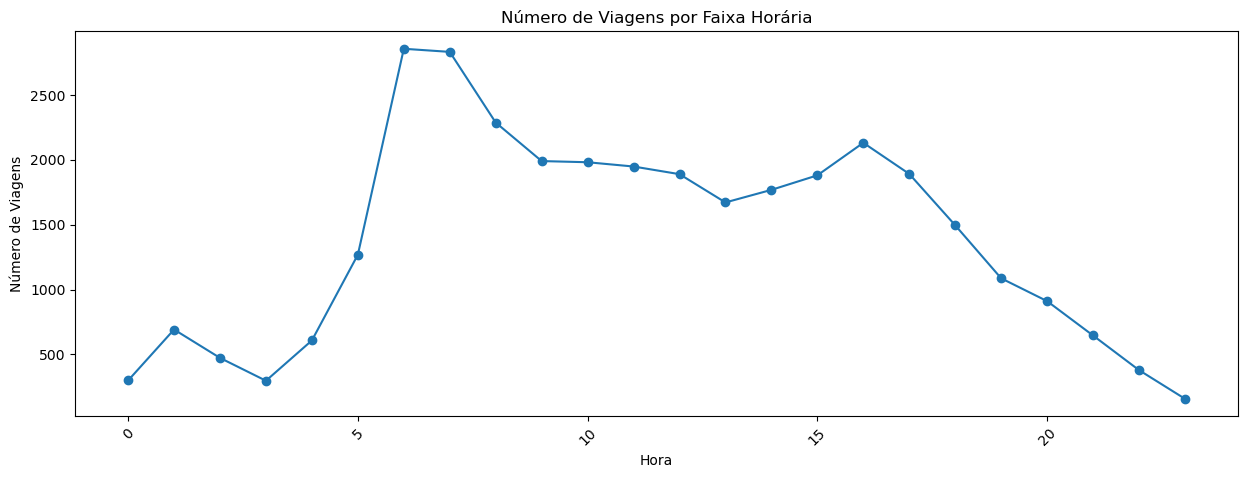

In [17]:
# Realizadno a contagem de viagens por faixa horaria
viagens_faixa_horaria = df_end.data_partida.apply(lambda x: x.hour).value_counts().sort_index().to_frame().reset_index(drop=False)
viagens_faixa_horaria.columns = ['Hora', 'Viagens']

# Certifique-se de que 'Hora'
viagens_faixa_horaria['Hora'] = viagens_faixa_horaria['Hora'].astype(int)

# Criando o gráfico
plt.figure(figsize=(15,5))
plt.plot(viagens_faixa_horaria['Hora'], viagens_faixa_horaria['Viagens'], marker='o')

# Ajustando rótulos do eixo X
plt.xticks(rotation=45)  # Girar os rótulos para melhor visualização
plt.xlabel('Hora')
plt.ylabel('Número de Viagens')
plt.title('Número de Viagens por Faixa Horária')

# Exibir gráfico
plt.show()

Aqui podemos ver o pico de manhã as 9h e o pico de tarde as 17h

In [18]:

viagens         = viagens_faixa_horaria.Viagens.copy() 
madrugada_manha = viagens.iloc[:12]
tarde_noite     = viagens.iloc[12:]

# ANALISE ESTATISTICA PARA PUXAR OUTLIER, NESSE CASO TEMOS AS HORAS PICO!!!!
vcut_m          = madrugada_manha[madrugada_manha    >= viagens.mean() * 0.75] # boxplot usa topo como 75%, outliers estão em menos de 25% dos dados
vcut_t          = tarde_noite    [tarde_noite        >= viagens.mean() * 0.75] # boxplot usa topo como 75%, outliers estão em menos de 25% dos dados

def choicerushrange(rushhour):

    rushhour["DIF_H1"]  = abs(rushhour.Hora - rushhour.Hora.shift(1).fillna(0))
    rushhour["DIF_H-1"] = abs(rushhour.Hora - rushhour.Hora.shift(-1).fillna(0))

    # SUBTRAINDO PARA CIMA E BAIXO E VENDO A DIFERENÇA HORARIA, SE FOR IGUAL AGRUP E PEGUE MAIOR!
    min_save = []
    for _, row in rushhour.iterrows(): min_save.append(min([row["DIF_H1"], row["DIF_H-1"]]))
    rushhour.drop(["DIF_H1","DIF_H-1"], axis=1, inplace=True)
    rushhour["GRUP"]    = pd.Series(min_save, index=rushhour.index)
    rushhour            = rushhour.loc[rushhour.groupby("GRUP")["Viagens"].idxmax()]
    rushhour.drop(["GRUP"], axis=1, inplace=True)
    return rushhour

RUSH1           = choicerushrange(viagens_faixa_horaria.loc[vcut_m[vcut_m >= vcut_m.mean() + vcut_m.std() * 0.5].index]) # 0.5 POIS HORA PICO PRESENTA MENOS DE 25% DOS DADOS, DISTRIBUIÇÃO QUASE NORMAL!
RUSH2           = choicerushrange(viagens_faixa_horaria.loc[vcut_t[vcut_t >= vcut_t.mean() + vcut_t.std() * 0.5].index]) # 0.5 POIS HORA PICO PRESENTA MENOS DE 25% DOS DADOS, DISTRIBUIÇÃO QUASE NORMAL!
HORA_DO_RUSH    = pd.concat([RUSH2, RUSH1], ignore_index=True).sort_values(['Hora'], ignore_index=True)
HORA_DO_RUSH

,Hora,Viagens
0,6,2857
1,12,1890
2,16,2132


# **QUAIS SERVIÇOS OPERAM MELHOR E QUAIS OPERAM PIOR ? 🤔**
### **(MAIOR REGULARIDADE) E (MENOR REGULARIDADE)**

## Calculando a Regulariedade do Serviço por Faixa Horária

In [19]:
df_end["hora"]                      = df_end["data_partida"].apply(lambda x: x.hour)

In [20]:
# QUANTIDADE DE VIAGENS PARA CADA SERVIÇO DENTRO DE CADA HORA
viagens_por_servico_hora            = df_end.groupby(by=["hora","servico"]).servico.value_counts().to_frame().reset_index(drop=False)
viagens_por_servico_hora.columns    = ["hora","servico","Viagens"]

# QUANTIDADE DE VIAGENS TOTAL PARA CADA HORA
viagens_por_hora                    = df_end.groupby(by=["hora"]).hora.value_counts().to_frame().reset_index(drop=False)
viagens_por_hora.columns            = ["hora","Total Viagens"]

# CRIANDO DATAFRAME DOS PESOS COM BASE NAS VIAGENS
df_pesos                                = viagens_por_servico_hora.merge(viagens_por_hora, on="hora")
df_pesos["PESO"]                        = df_pesos["Viagens"]/df_pesos["Total Viagens"]
df_pesos.drop(["Viagens","Total Viagens"], axis=1, inplace=True)

# PONTUAÇÃO TOTAL ATINGIDA
pontuacao_total_servico_mes_hora = df_end.groupby(by=["hora","servico"])\
                                            .score.mean()\
                                            .to_frame()\
                                            .sort_values(['score'], ascending=False)\
                                            .reset_index(drop=False)\
                                            .copy()

pontuacao_total_servico_mes_hora = pontuacao_total_servico_mes_hora.merge(df_pesos, on=["hora","servico"], how="left")
pontuacao_total_servico_mes_hora["SCORE_CORRIGIDO"] = pontuacao_total_servico_mes_hora["score"] * pontuacao_total_servico_mes_hora["PESO"]
pontuacao_total_servico_mes_hora.sort_values("SCORE_CORRIGIDO", inplace=True, ignore_index=tuple, ascending=False)
pontuacao_total_servico_mes_hora.drop(["PESO","score"], axis=1, inplace=True)
pontuacao_total_servico_mes_hora.rename(columns={"SCORE_CORRIGIDO":"score"}, inplace=True)
pontuacao_total_servico_mes_hora

,hora,servico,score
0,0,SN878,0.178691
1,1,SN878,0.119168
2,3,SN397,0.109307
3,0,SN550,0.095557
4,3,SN393,0.090669
...,...,...,...
4133,3,665,-0.000120
4134,5,906,-0.000141
4135,11,634,-0.000147
4136,21,SR388,-0.000166


## Servicos com a Maior Regulariedade por **Faixa Horária**

In [21]:
maior_regulariedade = pontuacao_total_servico_mes_hora.copy()
maior_regulariedade.sort_values(["score"], inplace=True, ignore_index=tuple, ascending=False)
maior_regulariedade

,hora,servico,score
0,0,SN878,0.178691
1,1,SN878,0.119168
2,3,SN397,0.109307
3,0,SN550,0.095557
4,3,SN393,0.090669
...,...,...,...
4133,3,665,-0.000120
4134,5,906,-0.000141
4135,11,634,-0.000147
4136,21,SR388,-0.000166


## Servicos com a Menor Regulariedade por **Faixa Horária**

In [22]:
maior_regulariedade = pontuacao_total_servico_mes_hora.copy()
maior_regulariedade.sort_values(["score"], inplace=True, ignore_index=tuple, ascending=True)
maior_regulariedade

,hora,servico,score
0,3,385,-0.000601
1,21,SR388,-0.000166
2,11,634,-0.000147
3,5,906,-0.000141
4,3,665,-0.000120
...,...,...,...
4133,3,SN393,0.090669
4134,0,SN550,0.095557
4135,3,SN397,0.109307
4136,1,SN878,0.119168


## Criando as **Subfaixas Horárias (15 min)**

In [23]:
# Criar faixas de horário
subfaixas_15min                     = pd.date_range(start="00:00", end="23:45", freq="15min").time
faixas_horarias                     = pd.DataFrame({"Inicio": subfaixas_15min})
faixas_horarias["Fim"]              = faixas_horarias["Inicio"].shift(-1, fill_value=subfaixas_15min[0])
faixas_horarias["SubFaixa15"]       = faixas_horarias["Inicio"].astype(str) + " - " + faixas_horarias["Fim"].astype(str)

# Converter para datetime para facilitar a comparação
faixas_horarias["Inicio"]           = pd.to_datetime(faixas_horarias["Inicio"], format='%H:%M:%S').dt.time
faixas_horarias["Fim"]              = pd.to_datetime(faixas_horarias["Fim"], format='%H:%M:%S').dt.time
faixas_horarias.reset_index(inplace=True)
faixas_horarias

,index,Inicio,Fim,SubFaixa15
0,0,00:00:00,00:15:00,00:00:00 - 00:15:00
1,1,00:15:00,00:30:00,00:15:00 - 00:30:00
2,2,00:30:00,00:45:00,00:30:00 - 00:45:00
3,3,00:45:00,01:00:00,00:45:00 - 01:00:00
4,4,01:00:00,01:15:00,01:00:00 - 01:15:00
...,...,...,...,...
91,91,22:45:00,23:00:00,22:45:00 - 23:00:00
92,92,23:00:00,23:15:00,23:00:00 - 23:15:00
93,93,23:15:00,23:30:00,23:15:00 - 23:30:00
94,94,23:30:00,23:45:00,23:30:00 - 23:45:00


In [24]:
# Converter datetime.time para minutos desde a meia-noite
def time_to_minutes(t): return t.hour * 60 + t.minute
faixas_horarias["Inicio_min"]       = faixas_horarias["Inicio"].map(time_to_minutes)
faixas_horarias["Fim_min"]          = faixas_horarias["Fim"].map(time_to_minutes)

# Criar um índice categórico baseado em hora
df_end["HoraCompleta"]         = df_end["data_partida"].dt.time
df_end["HoraMin"]              = df_end["HoraCompleta"].map(time_to_minutes)

# Criar bins para segmentação eficiente
bins                                = list(faixas_horarias["Inicio_min"]) + [time_to_minutes(pd.to_datetime(['23:59:00'], format='%H:%M:%S').time[0]) + 1] # Ultimo minuto do dia
labels                              = faixas_horarias["SubFaixa15"]

df_end["SubFaixa15"]           = pd.cut(
    df_end["HoraMin"], bins=bins, labels=labels, include_lowest=True, right=False
)

df_end.drop(columns=["HoraCompleta", "HoraMin"], inplace=True)
df_end.SubFaixa15              = df_end.SubFaixa15.astype(str)
df_end

,servico,score,data_partida,hora,SubFaixa15
0,117,1.321429,2024-12-07 10:22:38,10,10:15:00 - 10:30:00
1,SP805,1.321429,2024-12-15 08:52:00,8,08:45:00 - 09:00:00
2,848,1.321429,2024-12-10 18:46:33,18,18:45:00 - 19:00:00
3,117,1.321429,2024-12-07 07:51:27,7,07:45:00 - 08:00:00
4,117,1.321429,2024-12-07 09:33:52,9,09:30:00 - 09:45:00
...,...,...,...,...,...
33446,415,-0.214286,2024-12-27 11:32:48,11,11:30:00 - 11:45:00
33447,756,-0.214286,2024-12-10 06:04:17,6,06:00:00 - 06:15:00
33448,936,-0.214286,2024-12-17 08:43:59,8,08:30:00 - 08:45:00
33449,SR355,-0.214286,2024-12-06 06:53:30,6,06:45:00 - 07:00:00


## Calculando a Regulariedade do Serviço por SubFaixa Horária de 15 min

In [25]:
# QUANTIDADE DE VIAGENS PARA CADA SERVIÇO DENTRO DE CADA SUBFAIXA
viagens_por_servico_subfaixa            = df_end.groupby(by=["SubFaixa15","servico"]).servico.value_counts().to_frame().reset_index(drop=False)
viagens_por_servico_subfaixa.columns    = ["SubFaixa15","servico","Viagens"]

# QUANTIDADE DE VIAGENS TOTAL PARA CADA SUBFAIXA
viagens_por_subfaixa                    = df_end.groupby(by=["SubFaixa15"]).SubFaixa15.value_counts().to_frame().reset_index(drop=False)
viagens_por_subfaixa.columns            = ["SubFaixa15","Total Viagens"]

# CRIANDO DATAFRAME DOS PESOS COM BASE NAS VIAGENS
df_pesos                                = viagens_por_servico_subfaixa.merge(viagens_por_subfaixa, on="SubFaixa15")
df_pesos["PESO"]                        = df_pesos["Viagens"]/df_pesos["Total Viagens"]
df_pesos.drop(["Viagens","Total Viagens"], axis=1, inplace=True)
df_pesos

# PONTUAÇÃO TOTAL ATINGIDA 
pontuacao_total_servico_mes_subfaixa    = df_end.groupby(by=["SubFaixa15","servico"]).score.mean().to_frame().reset_index(drop=False)
pontuacao_total_servico_mes_subfaixa    = pontuacao_total_servico_mes_subfaixa.merge(df_pesos, on=["SubFaixa15","servico"], how="left")
pontuacao_total_servico_mes_subfaixa["SCORE_CORRIGIDO"] = pontuacao_total_servico_mes_subfaixa["score"] * pontuacao_total_servico_mes_subfaixa["PESO"]
pontuacao_total_servico_mes_subfaixa.sort_values("SCORE_CORRIGIDO", inplace=True, ignore_index=tuple, ascending=False)
pontuacao_total_servico_mes_subfaixa.drop(["PESO","score"], axis=1, inplace=True)
pontuacao_total_servico_mes_subfaixa.rename(columns={"SCORE_CORRIGIDO":"score"}, inplace=True)
pontuacao_total_servico_mes_subfaixa

,SubFaixa15,servico,score
0,23:45:00 - 00:00:00,SN298,0.520677
1,23:45:00 - 00:00:00,SN312,0.308271
2,00:15:00 - 00:30:00,SN878,0.285714
3,01:15:00 - 01:30:00,SN878,0.222888
4,03:15:00 - 03:30:00,SN393,0.213203
...,...,...,...
9663,05:45:00 - 06:00:00,906,-0.000591
9664,03:45:00 - 04:00:00,665,-0.000627
9665,08:30:00 - 08:45:00,936,-0.000756
9666,03:45:00 - 04:00:00,385,-0.003133


## Servicos com a Maior Regulariedade por **Subfaixas Horárias (15 min)**

In [26]:
maior_regulariedade_subfaixa15 = pontuacao_total_servico_mes_subfaixa.copy()
maior_regulariedade_subfaixa15.sort_values(["score"], inplace=True, ignore_index=tuple, ascending=False)
maior_regulariedade_subfaixa15

,SubFaixa15,servico,score
0,23:45:00 - 00:00:00,SN298,0.520677
1,23:45:00 - 00:00:00,SN312,0.308271
2,00:15:00 - 00:30:00,SN878,0.285714
3,01:15:00 - 01:30:00,SN878,0.222888
4,03:15:00 - 03:30:00,SN393,0.213203
...,...,...,...
9663,05:45:00 - 06:00:00,906,-0.000591
9664,03:45:00 - 04:00:00,665,-0.000627
9665,08:30:00 - 08:45:00,936,-0.000756
9666,03:45:00 - 04:00:00,385,-0.003133


## Servicos com a Menor Regulariedade por **Subfaixas Horárias (15 min)**

In [27]:
maior_regulariedade_subfaixa15 = pontuacao_total_servico_mes_subfaixa.copy()
maior_regulariedade_subfaixa15.sort_values(["score"], inplace=True, ignore_index=tuple, ascending=True)
maior_regulariedade_subfaixa15

,SubFaixa15,servico,score
0,00:00:00 - 00:15:00,SN600,-0.011905
1,03:45:00 - 04:00:00,385,-0.003133
2,08:30:00 - 08:45:00,936,-0.000756
3,03:45:00 - 04:00:00,665,-0.000627
4,05:45:00 - 06:00:00,906,-0.000591
...,...,...,...
9663,03:15:00 - 03:30:00,SN393,0.213203
9664,01:15:00 - 01:30:00,SN878,0.222888
9665,00:15:00 - 00:30:00,SN878,0.285714
9666,23:45:00 - 00:00:00,SN312,0.308271


## Agregando Avaliação Horaria a Avaliação por Subfaixa - **Ranking Final**

### AGRUPANDO POR SUBFAIXA HORARIA DE 15 MIN

In [28]:
pontuacao_total_servico_mes_subfaixa    = pontuacao_total_servico_mes_subfaixa.groupby(by="servico").score.mean().to_frame().reset_index(drop=False)
pontuacao_total_servico_mes_subfaixa.sort_values("score", ignore_index=True, inplace=True, ascending=False)
pontuacao_total_servico_mes_subfaixa

,servico,score
0,SN298,0.130149
1,SN878,0.111961
2,SN312,0.097659
3,SN848,0.082389
4,SN550,0.066375
...,...,...
380,SV790,0.000972
381,SR355,0.000891
382,415,0.000727
383,790,0.000646


### AGRUPANDO POR FAIXA HORARIA DE 1H

In [29]:
pontuacao_total_servico_mes_hora    = pontuacao_total_servico_mes_hora.groupby(by="servico").score.mean().to_frame().reset_index(drop=False)
pontuacao_total_servico_mes_hora.sort_values("score", ignore_index=True, inplace=True, ascending=False)
pontuacao_total_servico_mes_hora

,servico,score
0,SN878,0.110587
1,SN848,0.072792
2,SN550,0.065202
3,SN846,0.052747
4,SN393,0.038785
...,...,...
380,810,0.000319
381,785,0.000298
382,790,0.000230
383,110,0.000199


## **Ranking Final**

### Calculo

In [30]:
score_hora          = pontuacao_total_servico_mes_hora.rename(columns={"score":"score_hora"}).copy()
score_subfaixa15    = pontuacao_total_servico_mes_subfaixa.rename(columns={"score":"score_subfaixa15"}).copy()

ranking             = score_hora.merge(score_subfaixa15, on="servico")
ranking["score"]    = ranking["score_hora"] + ranking["score_subfaixa15"]
ranking.drop(["score_hora","score_subfaixa15"], axis=1, inplace=True)
ranking.sort_values("score", ignore_index=True, inplace=True, ascending=False)
ranking = ranking.reset_index(drop=False)
ranking.rename(columns={
    "index": "posicao"
}, inplace=True)
ranking.posicao     = ranking.posicao + 1
ranking

,posicao,servico,score
0,1,SN878,0.222548
1,2,SN298,0.157426
2,3,SN848,0.155180
3,4,SN550,0.131577
4,5,SN312,0.118394
...,...,...,...
380,381,785,0.001271
381,382,SR355,0.001269
382,383,790,0.000876
383,384,415,0.000870


### Normalizando o Score de **0 a 1**

>
>🔗 **REF.:** [Normalização](https://medium.com/data-hackers/normalizar-ou-padronizar-as-vari%C3%A1veis-3b619876ccc9)
>

In [31]:
SCORE_MAX   = ranking.score.max()
SCORE_MIN   = ranking.score.min()
ranking.score = (ranking.score - SCORE_MIN) / (SCORE_MAX - SCORE_MIN)
ranking

,posicao,servico,score
0,1,SN878,1.000000
1,2,SN298,0.706375
2,3,SN848,0.696250
3,4,SN550,0.589826
4,5,SN312,0.530385
...,...,...,...
380,381,785,0.002299
381,382,SR355,0.002292
382,383,790,0.000519
383,384,415,0.000489


### Transformando para porcentagem - ( Melhor para Paineis! )

In [32]:
ranking.score = ranking.score * 100
ranking.score = ranking.score.apply(lambda x: round(x, 3))
ranking

,posicao,servico,score
0,1,SN878,100.000
1,2,SN298,70.638
2,3,SN848,69.625
3,4,SN550,58.983
4,5,SN312,53.039
...,...,...,...
380,381,785,0.230
381,382,SR355,0.229
382,383,790,0.052
383,384,415,0.049


In [33]:
ranking.to_csv("Ranking.csv", sep=";", encoding="utf-8", index=False)

# **EMCAPSULANDO A PIPELINE 🔀🛠️**
Objetivo e ser reultilizado em futuras análises. <br>


In [34]:
### ESSE PIPELINE qualityService ENCONTRA-SE DESATUALIZADA!
### FIZ ATUALIZAÇÕES NOS INDICADORES AQUI NO COLAB DIA 23/02
### QUE NÃO SE ENCONTRAM NA qualityService NO MOMENTO.
###
### MAS MESMO ASSIM PEÇO QUE AVALIEM SE A ESTRUTURA SE FICOU 
### ALGO A DESEJAR, QUERO OPNIÕES CONSTRUTIVAS PARA A MINHA
### EVOLUÇÃO.
###
### MUITO OBRIGADO, TE TENHAM UM BOM DIA DE TRABALHO! 

from    pipelines.quality   import qualityService # type: ignore
from    datetime            import datetime

day_start   = datetime(2024,    12, 1)
day_end     = datetime(2024,    12, 31)

qs          = qualityService(day_start, day_end)
qs.run()

In [35]:
qs.getRushHour()                #   HORA PICO

,Hora,Viagens
0,6,2857
1,12,1890
2,16,2132


In [36]:
qs.getServiceRanking()          #   RANKING DOS SERVIÇOS

,posicao,servico,indicador
0,1,SN238,0.758022
1,2,SN312,0.61116
2,3,SP803,0.55828
3,4,SN399,0.539653
4,5,SN298,0.49154
...,...,...,...
380,381,426,0.067718
381,382,859,0.064476
382,383,SP329,0.064009
383,384,415,0.061801


In [37]:
qs.getRanking10()               #   TOP 10 MELHORES SERVIÇOS

,posicao,servico,indicador
0,1,SN238,0.758022
1,2,SN312,0.61116
2,3,SP803,0.55828
3,4,SN399,0.539653
4,5,SN298,0.49154
5,6,SN355,0.48524
6,7,LECD94,0.478861
7,8,380,0.477239
8,9,783,0.467195
9,10,SP309,0.465452


In [38]:
qs.getRankingBottom10()         #   TOP 10 PIORES SERVIÇOS

,posicao,servico,indicador
384,385,013,0.049436
383,384,415,0.061801
382,383,SP329,0.064009
381,382,859,0.064476
380,381,426,0.067718
379,380,809,0.069351
378,379,922,0.07268
377,378,SR355,0.073534
376,377,SPB326,0.073776
375,376,SV863,0.075535


In [39]:
qs.getRankingMaxHour()          #   TOP SERVICE POR FAIXA HORARIA

,hora,servico,score
0,0,SN312,0.984295
1,1,SN393,0.537179
2,2,SN399,0.800179
3,3,872,0.969339
4,4,872,0.984295
5,5,869,0.977191
6,6,616,0.723971
7,7,837,0.809077
8,8,921,0.744538
9,9,805,0.756069


In [40]:
qs.getRankingMinHour()          #   PIORES SERVIÇOS POR FAIXA HORARIA

,hora,servico,score
0,0,SN848,0.106229
1,1,SN848,0.106758
2,2,790,0.050275
3,3,665,0.017453
4,4,SP329,0.052978
5,5,696,0.002955
6,6,558,0.011728
7,7,926,0.018043
8,8,SR355,0.042017
9,9,936,0.043299


In [41]:
qs.getRankingMaxRushHour()      #   OS MELHORES SERVIÇOS NA HORA PICO

,hora,servico,score
0,6,616,0.723971
1,12,201,0.680672
2,16,327,0.704326


In [42]:
qs.getRankingMinRushHour()      #   OS PIORES SERVIÇOS NA HORA PICO

,hora,servico,score
0,6,558,0.011728
1,12,685,0.005312
2,16,315,0.036241


In [43]:
qs.getRankingMaxSubfaixa15()    #   TOP SERVIÇOS POR FAIXA HORARIA DE 15 MIN

,servico,score,data_partida,hora,SubFaixa15
0,SN861,1.0,2024-12-05 01:00:45,1,01:00:00 - 01:15:00
1,869,1.0,2024-12-04 05:19:37,5,05:15:00 - 05:30:00
2,SN298,0.992083,2024-12-02 22:34:49,22,22:30:00 - 22:45:00
3,SPA613,0.987874,2024-12-11 15:40:48,15,15:30:00 - 15:45:00
4,SN954,0.986116,2024-12-21 00:49:38,0,00:45:00 - 01:00:00
...,...,...,...,...,...
91,SN397,0.507975,2024-12-07 01:58:40,1,01:45:00 - 02:00:00
92,624,0.507022,2024-12-05 10:26:34,10,10:15:00 - 10:30:00
93,SN388,0.470965,2024-12-20 03:03:48,3,03:00:00 - 03:15:00
94,SN368,0.410719,2024-12-31 01:21:14,1,01:15:00 - 01:30:00


In [44]:
qs.getRankingMinSubfaixa15()    #   PIORES SERVIÇOS POR FAIXA HORARIA DE 15 MIN

,servico,score,data_partida,hora,SubFaixa15
0,410,0.0,2024-12-04 05:56:27,5,05:45:00 - 06:00:00
1,SP343,0.001077,2024-12-27 06:05:11,6,06:00:00 - 06:15:00
2,867,0.00139,2024-12-14 07:23:00,7,07:15:00 - 07:30:00
3,LECD97,0.002001,2024-12-04 11:52:38,11,11:45:00 - 12:00:00
4,LECD97,0.002299,2024-12-20 12:10:55,12,12:00:00 - 12:15:00
...,...,...,...,...,...
91,SN600,0.092437,2024-12-18 00:45:19,0,00:45:00 - 01:00:00
92,SN803,0.097621,2024-12-04 03:24:02,3,03:15:00 - 03:30:00
93,SN848,0.098607,2024-12-28 01:34:41,1,01:30:00 - 01:45:00
94,SN848,0.098607,2024-12-02 02:18:40,2,02:15:00 - 02:30:00


In [45]:
qs.getRankingMaxRushHour()      #   MELHORES SERVIÇOS POR HORA PICO

,hora,servico,score
0,6,616,0.723971
1,12,201,0.680672
2,16,327,0.704326


In [46]:
qs.getRankingMinRushHour()      #   PIORES SERVIÇOS POR HORA PICO

,hora,servico,score
0,6,558,0.011728
1,12,685,0.005312
2,16,315,0.036241


# **PROVA REAL - CHECK ✅ !!**

In [47]:
check_services = [
    '006', 
    '865', 
    '422', 
    '834', 
    '813', 
    '301', 
    '842', 
    '847'
]
for service in check_services:
    print("SERVICE: {}, SCORE: {}".format(service, qs.getScoreService(service)))

SERVICE: 006, SCORE: 0.12422060329364729
SERVICE: 865, SCORE: 0.07779464030770919
SERVICE: 422, SCORE: 0.09886818470208197
SERVICE: 834, SCORE: -1
SERVICE: 813, SCORE: -1
SERVICE: 301, SCORE: 0.2626676273462252
SERVICE: 842, SCORE: 0.09487694498342583
SERVICE: 847, SCORE: 0.10853004390891915


In [48]:
from IPython.display import HTML
import os

path = os.path.join("addons","ProvaFinal","XequeMate.html")
with open(path, "r") as file: html = file.read()
HTML(html)

# **FIM!**

---

## 📌 Observações  

- Espero que este trabalho tenha atendido às expectativas e que a construção do módulo `quality.py` seja devidamente avaliada.  
  Dediquei uma parte significativa do desafio para estruturar o processo, então peço que considerem esse aspecto também. 👨‍💻👌  

---

### 🚀 A experiência  
Ser um Engenheiro de Transportes e lidar com esses dados foi incrível! Foi um prazer participar deste desafio.  
Até uma próxima oportunidade! 🙌  

---

### 🔍 Feedback  
Ah, mais um detalhe! Caso eu não seja selecionado, gostaria de receber um motivo construtivo para aprimorar minhas habilidades.  
Ficarei decepcionado se a resposta for apenas **"Seu perfil não bate"** kkkkk. Quero opiniões que realmente agreguem!  

---
